## Notebook to generate data for Viki's Machine Learning project
Use ReadIn_new.ipynb

In [93]:
from matplotlib import pyplot as plt
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')
import pandas as pd

In [12]:
""" PROCESSING: A new sampling function 
    Fixed distance from the surface instead of wave following coordinate. """
from scipy import interpolate
def sampling(array_simu, case, hsample, eta):
    """ This function is similar to array_newcoord, but instead of mapping 2D, it only samples one line at 
        a given height hsample (in cartesian coordinate away from the surface.
        Args:
            array_simu: simulation output 2D array to sample.
            case: case object for metadata like h, ak and k. 
        Returns:
            array_interp: 1D interpolated field (N*1).
            z_interp: 1D interpolate position (N*1). """
    h = case.h; L0=case.L0; N = case.N
    xarray = np.linspace(-np.pi, np.pi, N)
    array_interp = np.zeros(np.shape(array_simu[-1]))
    z_interp = np.zeros(np.shape(array_simu)[-1])
    # Do 1d interpolation for each x
    for i in range(np.shape(array_simu)[0]):
        xi = xarray[i]
        # Grid in simulation, translated vertically to have the resting interface at z=0
        z_simu = np.linspace(0,L0,N,endpoint=False) + L0/2/N - h 
        f = interpolate.interp1d(z_simu, array_simu[i,:], fill_value="extrapolate")
        # Explicitly computed corresponding z, using a0cos(kxi)
        z_grid = eta[i] + hsample
        array_grid = f(z_grid)
        array_interp[i] = array_grid
        z_interp[i] = z_grid
    return (array_interp, z_interp)

In [ ]:
def find_dphase3 (p2D, eta, case):
    p2D_sample, zsample = sampling(p2D, case=case, hsample=0.02*2*np.pi/case.k, eta=eta)
    p2D_interp, zgrid = array_newcoord(p2D, case=case, eta=eta)
    spectrum1 = np.fft.fft(p2D_interp[:,88]-np.average(p2D_interp[:,88]))
    spectrum2 = np.fft.fft(p2D_interp[:,90]-np.average(p2D_interp[:,90]))
    spectrum3 = np.fft.fft(p2D_sample-np.average(p2D_sample))     
    phase = np.array((np.angle(spectrum1)[4]/2/np.pi*360, np.angle(spectrum2)[4]/2/np.pi*360, np.angle(spectrum3)[4]/2/np.pi*360))
    amplitude = np.array((np.abs(spectrum1)[4], np.abs(spectrum2)[4], np.abs(spectrum3)[4]))*2/512
    return phase, amplitude

In [96]:
""" Compile all the field and write to files """
case = case2
for index in range(5,25):
    # eta (1D)
    xarray = np.linspace(-np.pi, np.pi, 512)
    etai = np.where(np.isclose(case.phase['t'], case.p['t'][index]))[0][0]
    eta = np.roll(np.average(case.phase['eta'][etai], axis=0), -case.phase['idx'][etai], axis=0) - 1
    # u (1D)
    samplei = 100
    fieldi = np.where(np.isclose(case.field_t, case.p['t'][index]))[0][0]
    ux = case.ux_2D[fieldi][:,samplei]
    # v (1D)
    uy = case.uy_2D[fieldi][:,samplei]
    # pressure (1D)
    p2D_sample, zsample = sampling(case.p['p_2D'][index], case=case, hsample=0.02*2*np.pi/case.k, eta=eta)
    print('Eta taken at t = %g, field taken at t = %g, pressure taken at t = %g' %(case.phase['t'][etai],case.field_t[fieldi],case.p['t'][index]))
    """ Write to file """
    df = pd.DataFrame({'x' : xarray, 'eta' : eta, 'u' : ux, 'v' : uy, 'pressure' : p2D_sample})
    formats = {'x': '{:.5f}', 'eta': '{:.5f}', 'u': '{:.5f}', 'v': '{:.5f}', 'pressure': '{:.7f}'}
    for col, f in formats.items():
        df[col] = df[col].map(lambda x: f.format(x))
    df.to_csv("Viki/CU%.0f/CU%.0f_t%g.csv" %(case.wave.c/case.ustar,case.wave.c/case.ustar,case.p['t'][index]), index=False)

Eta taken at t = 6, field taken at t = 6, pressure taken at t = 6
Eta taken at t = 7, field taken at t = 7, pressure taken at t = 7
Eta taken at t = 8, field taken at t = 8, pressure taken at t = 8
Eta taken at t = 9, field taken at t = 9, pressure taken at t = 9
Eta taken at t = 10, field taken at t = 10, pressure taken at t = 10
Eta taken at t = 11, field taken at t = 11, pressure taken at t = 11
Eta taken at t = 12, field taken at t = 12, pressure taken at t = 12
Eta taken at t = 13, field taken at t = 13, pressure taken at t = 13
Eta taken at t = 14, field taken at t = 14, pressure taken at t = 14
Eta taken at t = 15, field taken at t = 15, pressure taken at t = 15
Eta taken at t = 16, field taken at t = 16, pressure taken at t = 16
Eta taken at t = 17, field taken at t = 17, pressure taken at t = 17
Eta taken at t = 18, field taken at t = 18, pressure taken at t = 18
Eta taken at t = 19, field taken at t = 19, pressure taken at t = 19
Eta taken at t = 20, field taken at t = 20, pr

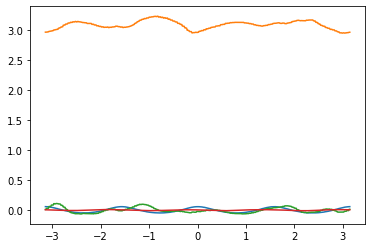

In [42]:
plt.plot(xarray, eta)
plt.plot(xarray, ux)
plt.plot(xarray, uy)
plt.plot(xarray, p2D_sample/0.25**2)

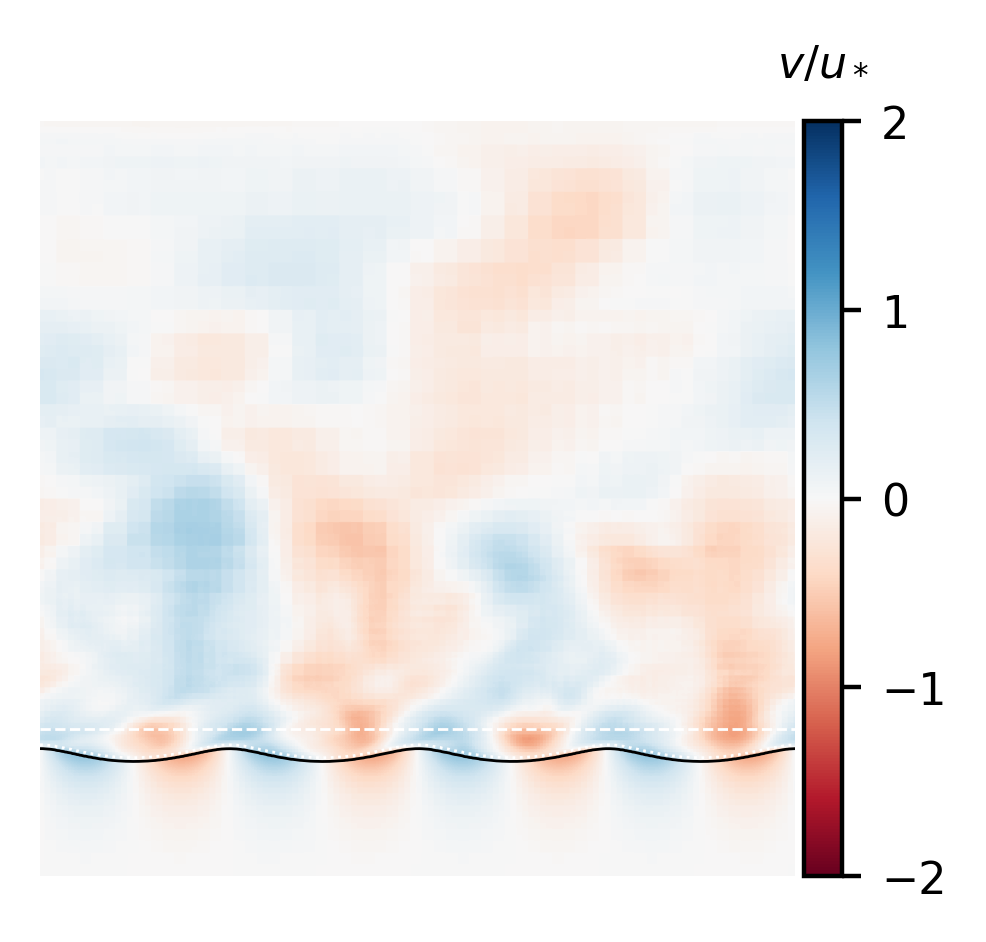

In [99]:
fig = plt.figure(figsize=[3,2.5])
img = plt.imshow(np.rot90(case.uy_2D[fieldi]/case.ustar), cmap='RdBu', extent=[-np.pi,np.pi,-1,2*np.pi-1], vmax=2, vmin=-2)
plt.axis('off')
plt.plot(xarray, eta, c='k', lw=0.5)
plt.plot(xarray, eta+0.02*2*np.pi/case.k, ':', c='w', lw=0.5)
plt.plot(xarray, xarray/xarray*100/512*2*np.pi-1, '--', c='w', lw=0.5)
cbar = fig.colorbar(img, orientation="vertical", pad=0.01)
cbar.set_ticks([-2,-1,0,1,2])
cbar.ax.text(0.5, 1.08, r'$v/u_*$', ha='center', va='center', transform=cbar.ax.transAxes)
fig.savefig('Viki/Illustration.png', bbox_inches='tight', pad_inches=0.2)

The sampling line is about 1/8 wave length from the mean water surface.

In [72]:
(1 + 2*np.pi/4/8)/2/np.pi * 512

97.48733086305042

In [97]:
case.wave.c

1.002496882788171